Lien vers le video:
https://mega.nz/file/QtsjWD6b#x9mXPyWfiO6vA9Fy2Q79gBaLVBCIQrZddtdNUN3PYPk

In [ ]:
!pip install spotipy

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 138 kB 25.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import sys
import itertools

import plotly.express as px


from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [ ]:
sns.set(rc={'figure.figsize':(14 ,8)})

## 1.  Data Expoloration / Data Preparation :

First we are going to run some EDA on our datasets.

    spotify_df : Dataframe of the +1.2m songs that we are going to recommend from.
  
    years_df : Dataframe by year (last 100 years).
  
    artists_df : Dataframe by artist.
  
    genres_df : Dataframe by genre.

In [ ]:
spotify_df = pd.read_csv('./data/tracks_features.csv')
genres_df = pd.read_csv('./data/data_by_genres.csv')
artists_df = pd.read_csv('./data/data_by_artist.csv')
years_df = pd.read_csv('./data/data_by_year.csv')

In [ ]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264168 entries, 0 to 264167
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                264168 non-null  object 
 1   name              264168 non-null  object 
 2   album             264168 non-null  object 
 3   album_id          264167 non-null  object 
 4   artists           264167 non-null  object 
 5   artist_ids        264167 non-null  object 
 6   track_number      264167 non-null  float64
 7   disc_number       264167 non-null  float64
 8   explicit          264167 non-null  object 
 9   danceability      264167 non-null  float64
 10  energy            264167 non-null  float64
 11  key               264167 non-null  float64
 12  loudness          264167 non-null  float64
 13  mode              264167 non-null  float64
 14  speechiness       264167 non-null  float64
 15  acousticness      264167 non-null  float64
 16  instrumentalness  26

In [ ]:
spotify_df.isnull().sum()

id                  0
name                0
album               0
album_id            0
artists             0
artist_ids          0
track_number        0
disc_number         0
explicit            0
danceability        0
energy              0
key                 1
loudness            1
mode                1
speechiness         1
acousticness        1
instrumentalness    1
liveness            1
valence             1
tempo               1
duration_ms         1
time_signature      1
year                1
release_date        1
dtype: int64

In [ ]:
spotify_df.dropna(inplace=True)

In [ ]:
spotify_df.describe()

,track_number,disc_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
count,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,267923.000000,2.679230e+05,267923.000000,267923.000000
mean,7.583907,1.036697,0.490175,0.509714,5.202831,-11.800464,0.684223,0.080869,0.449615,0.282684,0.200856,0.437896,117.719869,2.485943e+05,3.828749,2003.724484
std,5.551166,0.229400,0.184768,0.292504,3.528105,6.775920,0.464826,0.116451,0.383146,0.375387,0.180665,0.271009,30.991647,1.489585e+05,0.568114,9.112070
min,1.000000,1.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.000000,1909.000000
25%,3.000000,1.000000,0.357000,0.256000,2.000000,-15.044500,0.000000,0.034400,0.040000,0.000011,0.096600,0.201000,94.466000,1.765720e+05,4.000000,2000.000000
50%,7.000000,1.000000,0.498000,0.518000,5.000000,-9.971000,1.000000,0.043500,0.404000,0.009040,0.124000,0.417000,116.403000,2.277070e+05,4.000000,2005.000000
75%,10.000000,1.000000,0.626000,0.766000,8.000000,-6.903000,1.000000,0.067900,0.856000,0.714000,0.243000,0.657000,136.987000,2.879070e+05,4.000000,2009.000000
max,50.000000,9.000000,0.990000,1.000000,11.000000,4.651000,1.000000,0.969000,0.996000,1.000000,1.000000,1.000000,246.130000,6.054655e+06,5.000000,2020.000000


In [ ]:
years_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [ ]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [ ]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              28680 non-null  int64  
 1   count             28680 non-null  int64  
 2   acousticness      28680 non-null  float64
 3   artists           28680 non-null  object 
 4   danceability      28680 non-null  float64
 5   duration_ms       28680 non-null  float64
 6   energy            28680 non-null  float64
 7   instrumentalness  28680 non-null  float64
 8   liveness          28680 non-null  float64
 9   loudness          28680 non-null  float64
 10  speechiness       28680 non-null  float64
 11  tempo             28680 non-null  float64
 12  valence           28680 non-null  float64
 13  popularity        28680 non-null  float64
 14  key               28680 non-null  int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 3.3+ MB


### Correlation Heatmap:
  There is a high correlation between energy and loudness. Which is intuitive, since energetic songs are louder, faster and noisier.
  
  There is also a negative correlation between acousticness and energy/loudness: acoustic songs are more calm and slow paced.

  Valence and Danceability are also correlated to a degree, since valence describes the musical positiveness in the song. This can be explained by the fact that a danceable song will more likely have a positive tone.

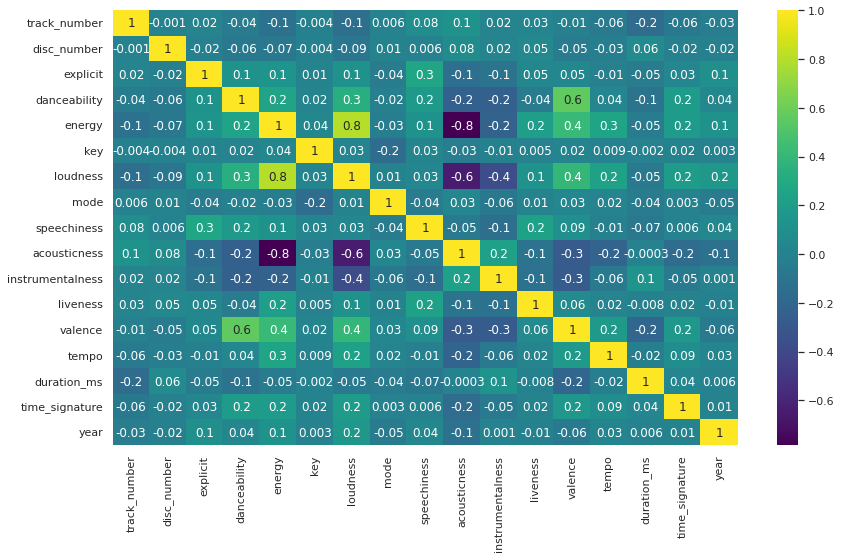

In [ ]:
sns.heatmap(spotify_df.corr(), annot=True, fmt='.1g', cmap="viridis")

Most of the songs in the million songs dataset are from the 21st century :

In [ ]:
spotify_df = spotify_df.sort_values(by='year')

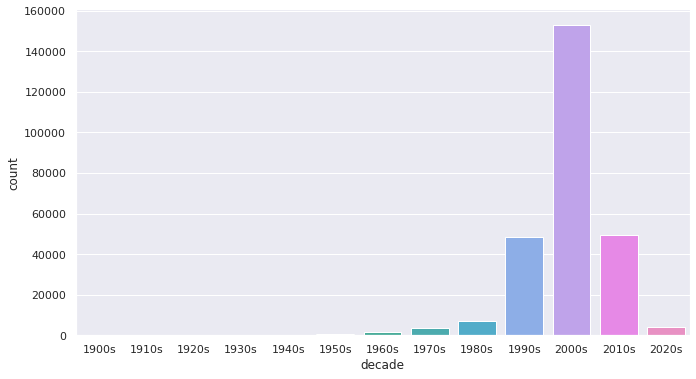

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

spotify_df['decade'] = spotify_df['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(spotify_df['decade'])

### Evolution of Music through time :

We see that through time songs became less acoustic and instrumental, and more energetic and danceable.

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence', 'speechiness']
fig = px.line(years_df, x='year', y=sound_features)
fig.show()

### Top 10 genres:
We observe that danceability, energy, and valence are the three common points for popular genres. Thus, the importance of these three key elements for a song/genre to be popular.

In [ ]:
top_10_genres = genres_df.nlargest(10, 'popularity')
fig = px.bar(top_10_genres, x='genres', y=sound_features, barmode='group')
fig.show()

### Top 10 artists :
Same observations for genres: danceability, energy, and valence.


In [ ]:
top_10_artists = artists_df.nlargest(10, 'popularity')
fig = px.bar(top_10_artists, x='artists', y=sound_features, barmode='group')
fig.show()

# 2. Recommendation Model: K-Means Clustering

We are going to cluster the songs in the million song dataset.
First step will be to decide the number K for clusters, for that we are going to use the elbow method.

Since the dataset is very large, we are going to run it on a sample of 50000 songs.


In [ ]:
sample_spotify_df = spotify_df.sample(n = 50000)
X = sample_spotify_df.select_dtypes(np.number).drop(['year'], axis=1)

In [ ]:
K=range(5,25)
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(X)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
cluster_scores = pd.DataFrame({'Clusters' : K, 'WSS' : wss})

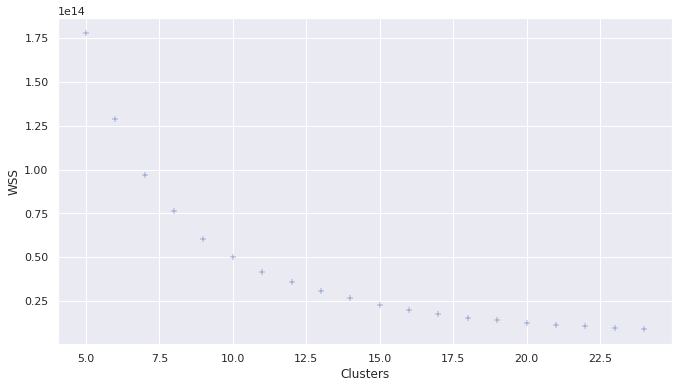

In [ ]:
sns.scatterplot(x = 'Clusters', y = 'WSS', data = cluster_scores, marker="+")

Then, we choose K = 12. Which means we will be having 12 clusters.

Now, we are going to apply a standard scaler on the dataset, and fit it to the k-means clustering model.

In [ ]:
K = 12

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=K, 
                                   verbose=False))
                                 ], verbose=False)

X = spotify_df.select_dtypes(np.number).drop(['year'], axis=1)

number_cols = list(X.columns)
print(number_cols)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
spotify_df['cluster_label'] = song_cluster_labels

['track_number', 'disc_number', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


To visualize this clustering we will apply a PCA on our data.

In [ ]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = spotify_df['name']
projection['cluster'] = spotify_df['cluster_label']

fig = px.scatter(
    projection.sample(n=100), x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In [ ]:
#Authenticate
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        client_id="f8a8d16218b04ceb93755f638172218a",
        client_secret="74f5006901754cd4bc3f6becf2c942e7"
    )
) 

We get the user's playlist from spotify API

In [ ]:
playlist_link = "https://open.spotify.com/playlist/1tvW7L7G0x3pmM933aTXu8?si=7e4fdee271694efd"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
sp.playlist_tracks(playlist_URI)["items"][-1]

In [ ]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

playlist_songs = []
for song in get_playlist_tracks('Aymane.liebert', playlist_URI):
    playlist_songs.append({
                        'id':song['track']['id'],
                        'artists':[ i['name'] for i in song['track']['artists'] ],
                        'name':song['track']['name'],
                        'track_number': song['track']['track_number'],
                        'disc_number': song['track']['disc_number']
                })
playlist_songs[0]

{'artists': ['YOASOBI'],
 'disc_number': 1,
 'id': '06XQvnJb53SUYmlWIhUXUi',
 'name': '怪物',
 'track_number': 1}

Then we get the audio features of the songs

In [ ]:
playlist_dict = []

def get_features(playlist_songs):
    print('Getting Playlist Song Features')
    for id_ in playlist_songs:
        dict_ = sp.audio_features(id_['id'])[0]
        dict_.update(id_)
        playlist_dict.append(dict_)

get_features(playlist_songs)
# playlist_dict


Getting Playlist Song Features


And here is the user's playlist with all the features

In [ ]:
playlist_df = pd.DataFrame(playlist_dict)
playlist_df = playlist_df.drop(['analysis_url', 'track_href', 'uri', 'type'], axis=1)
playlist_df = playlist_df[list(playlist_df.columns.values)[::-1]]
playlist_df.head()

,disc_number,track_number,name,artists,time_signature,duration_ms,id,tempo,valence,liveness,instrumentalness,acousticness,speechiness,mode,loudness,key,energy,danceability
0,1,1,怪物,[YOASOBI],4,206000,06XQvnJb53SUYmlWIhUXUi,169.935,0.7740,0.3100,0.000066,0.0699,0.1180,1,-3.419,1,0.824,0.627
1,1,1,Wildflower Wildfire,[Lana Del Rey],5,286741,5WhzJEUErG4gdSqxNCB9ED,79.592,0.2110,0.1130,0.032700,0.8760,0.0323,0,-10.026,7,0.224,0.352
2,1,6,National Anthem,[Lana Del Rey],4,230520,7cNz65PfCatRXoX7QtqM2A,85.000,0.4360,0.0957,0.000146,0.5310,0.2440,0,-5.935,0,0.899,0.532
3,1,9,California,[Lana Del Rey],4,305900,7oTE1KmtU2ml9zBhv9Reao,123.758,0.1950,0.0631,0.000000,0.7610,0.0317,0,-8.067,9,0.410,0.449
4,1,2,Ultraviolence,[Lana Del Rey],3,251480,1y3r6RXiJZNBV1EI0NggpS,79.262,0.0899,0.1010,0.000010,0.2780,0.0380,1,-7.076,0,0.541,0.144


We plot the distribution plots of the playlist sound features

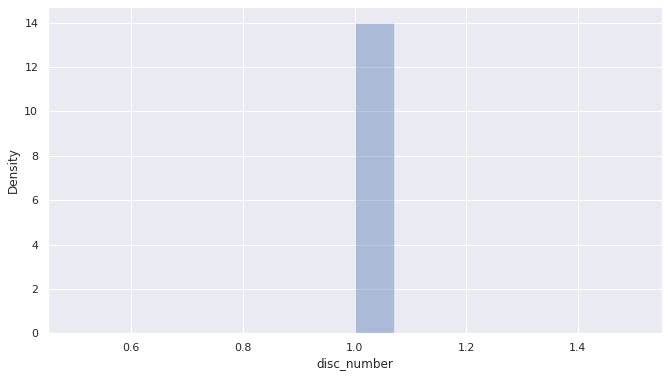

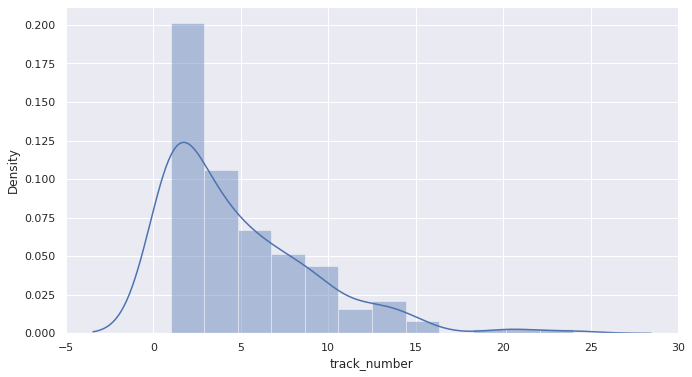

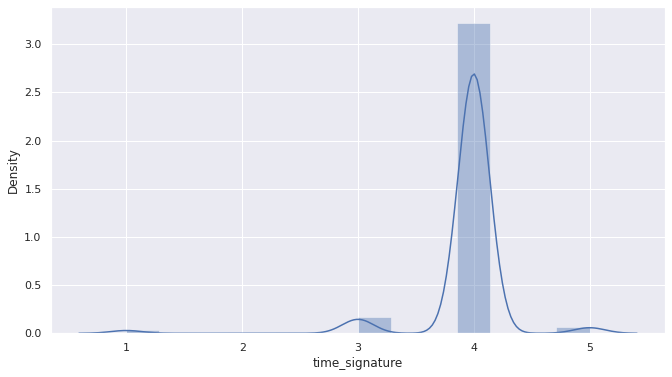

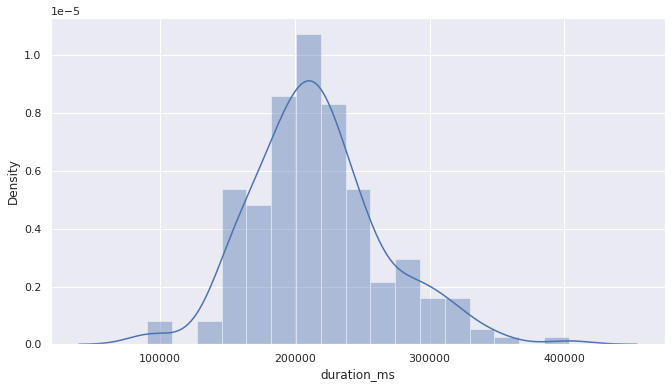

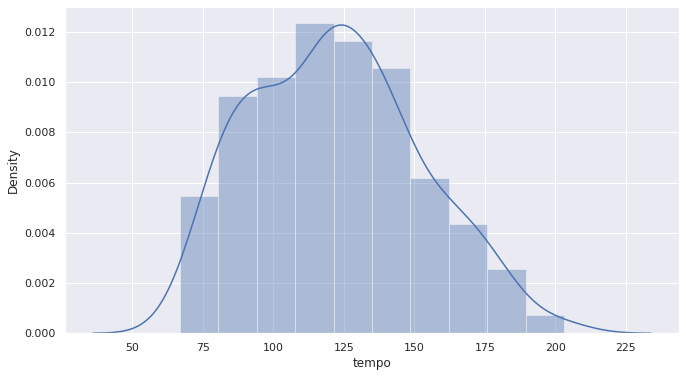

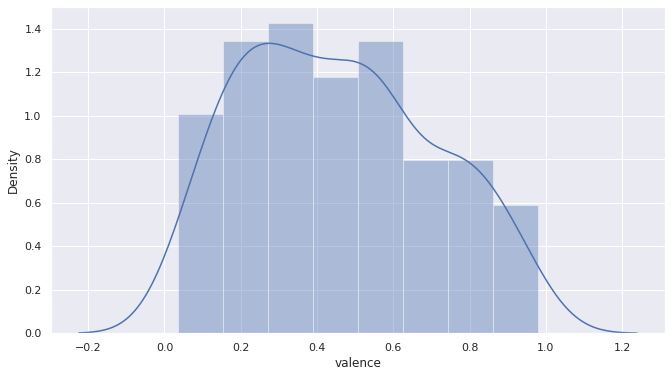

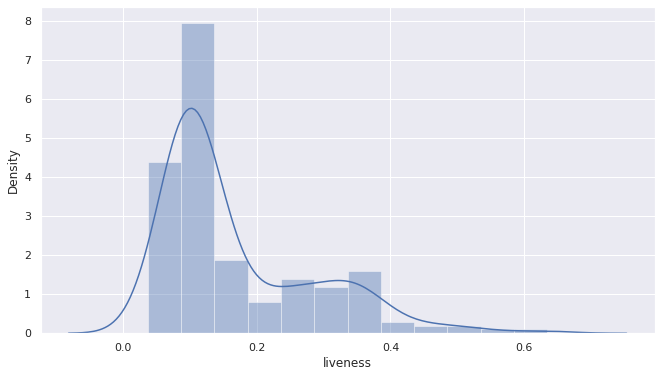

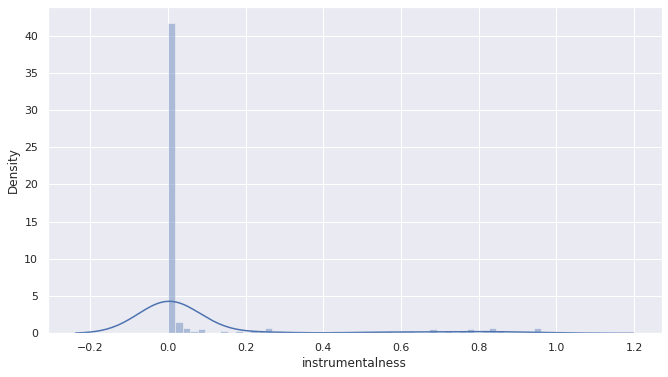

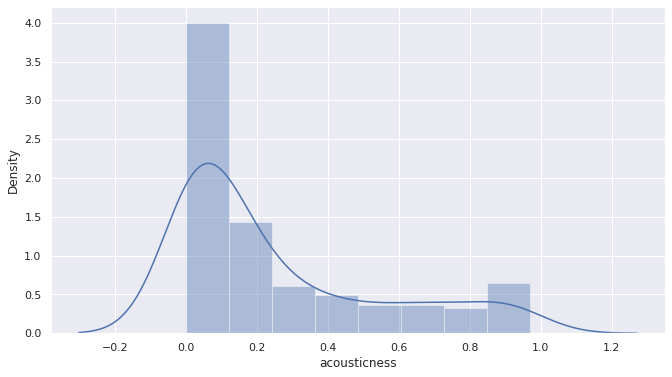

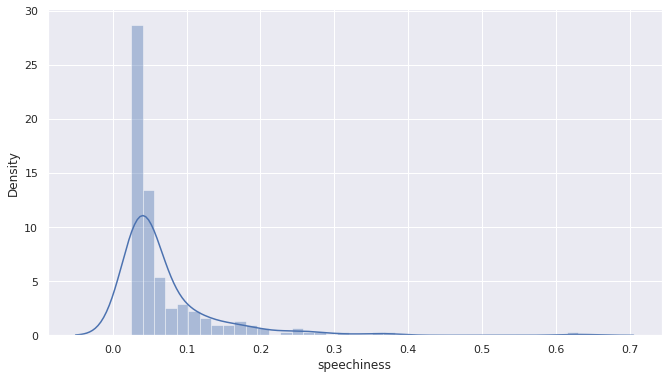

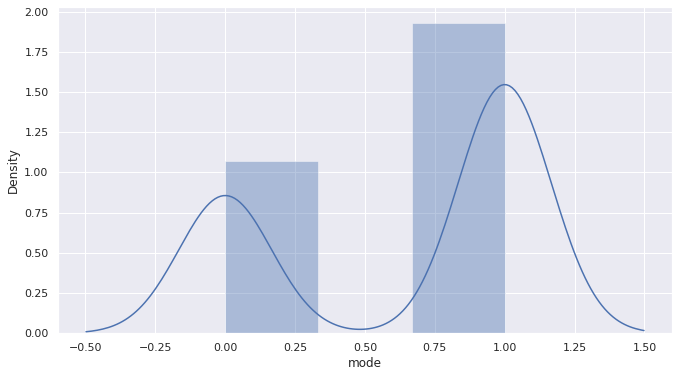

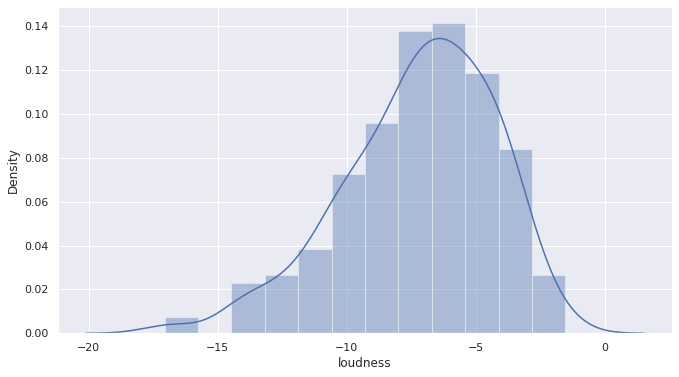

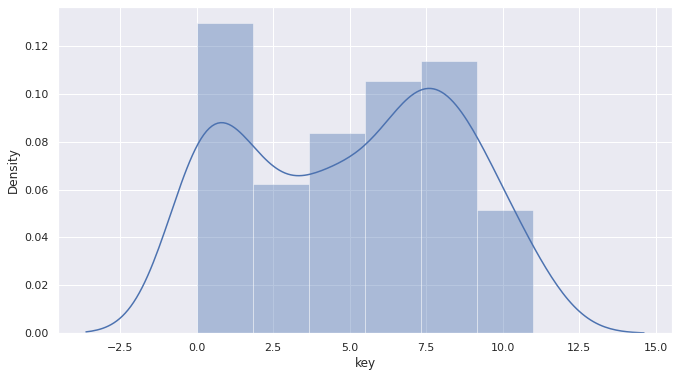

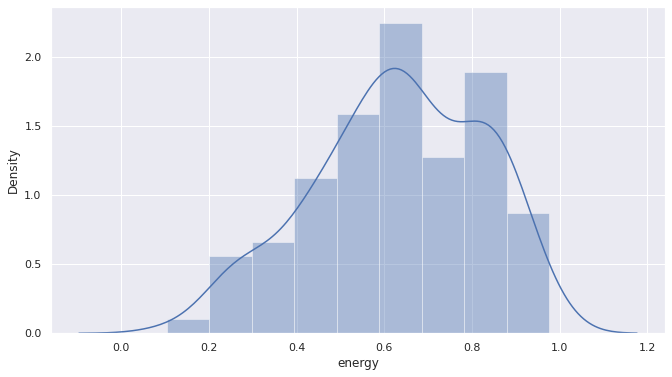

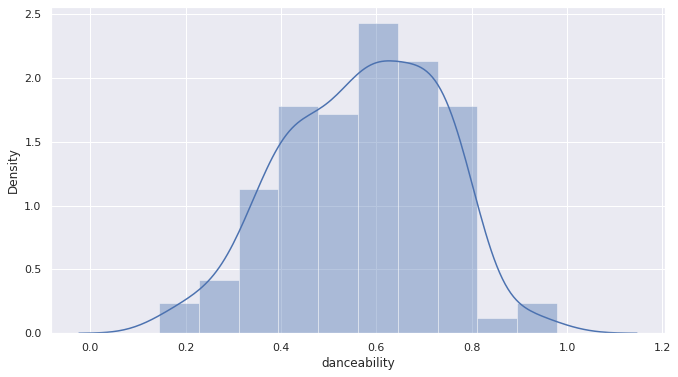

In [ ]:
for (i, feature) in enumerate(list(playlist_df.select_dtypes(np.number).columns)):
  plt.figure(i)
  sns.distplot(playlist_df[feature])


Then we predict the cluster of the playlist songs using the previous k-means model

In [ ]:
Y = playlist_df.select_dtypes(np.number)
number_cols = list(Y.columns)
print(number_cols)
song_cluster_pipeline.fit(Y)
playlist_cluster_labels = song_cluster_pipeline.predict(Y)
playlist_df['cluster_label'] = playlist_cluster_labels


['disc_number', 'track_number', 'time_signature', 'duration_ms', 'tempo', 'valence', 'liveness', 'instrumentalness', 'acousticness', 'speechiness', 'mode', 'loudness', 'key', 'energy', 'danceability']


In [ ]:
playlist_df

,disc_number,track_number,name,artists,time_signature,duration_ms,id,tempo,valence,liveness,instrumentalness,acousticness,speechiness,mode,loudness,key,energy,danceability,cluster_label
0,1,1,怪物,[YOASOBI],4,206000,06XQvnJb53SUYmlWIhUXUi,169.935,0.7740,0.3100,0.000066,0.069900,0.1180,1,-3.419,1,0.824,0.627,2
1,1,1,Wildflower Wildfire,[Lana Del Rey],5,286741,5WhzJEUErG4gdSqxNCB9ED,79.592,0.2110,0.1130,0.032700,0.876000,0.0323,0,-10.026,7,0.224,0.352,1
2,1,6,National Anthem,[Lana Del Rey],4,230520,7cNz65PfCatRXoX7QtqM2A,85.000,0.4360,0.0957,0.000146,0.531000,0.2440,0,-5.935,0,0.899,0.532,8
3,1,9,California,[Lana Del Rey],4,305900,7oTE1KmtU2ml9zBhv9Reao,123.758,0.1950,0.0631,0.000000,0.761000,0.0317,0,-8.067,9,0.410,0.449,1
4,1,2,Ultraviolence,[Lana Del Rey],3,251480,1y3r6RXiJZNBV1EI0NggpS,79.262,0.0899,0.1010,0.000010,0.278000,0.0380,1,-7.076,0,0.541,0.144,5
5,1,1,Mamma Mia,[ABBA],4,213267,2TxCwUlqaOH3TIyJqGgR91,137.547,0.8270,0.4690,0.000443,0.295000,0.0323,1,-7.011,2,0.748,0.749,2
6,1,6,Does Your Mother Know,[ABBA],4,193440,2HPB3px8MJZRMfu1L65Z41,135.571,0.9750,0.0906,0.000024,0.151000,0.0364,1,-5.680,7,0.865,0.728,3
7,1,4,Off The Grid,[Kanye West],4,339250,2gbMPBrBVj3CuNTLp2dHYs,137.728,0.6300,0.1370,0.000000,0.043800,0.3700,1,-5.582,8,0.640,0.546,8
8,1,4,Forever,[Labrinth],4,202536,6potEImiklXkwD9qFzpu15,79.983,0.1970,0.1100,0.724000,0.920000,0.0292,0,-7.781,4,0.459,0.563,7
9,1,5,The Beach,[The Neighbourhood],4,255133,2u0CelO5c81XS7z3dGpHbS,135.739,0.1050,0.0766,0.000008,0.131000,0.0608,0,-7.426,2,0.640,0.245,9


Now, to recommend songs we have to do that based on the distribution of each cluster, which means if cluster 3 is 40% of the songs, then the recommended playlist must 40% of the cluster 3

In [ ]:
cluster_counts = {}

for i in range(K):
  cluster_counts[i] = playlist_df[playlist_df['cluster_label'] == i].shape[0] / playlist_df.shape[0]


print(cluster_counts)

{0: 0.0891089108910891, 1: 0.06930693069306931, 2: 0.12871287128712872, 3: 0.14356435643564355, 4: 0.04950495049504951, 5: 0.06435643564356436, 6: 0.12376237623762376, 7: 0.06930693069306931, 8: 0.054455445544554455, 9: 0.12376237623762376, 10: 0.009900990099009901, 11: 0.07425742574257425}


In [ ]:
print(X.columns)

Index(['track_number', 'disc_number', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')


In [ ]:
print(mean_cluster)

disc_number              1.000000
track_number             3.055556
time_signature           3.944444
duration_ms         214988.166667
tempo                  125.313333
valence                  0.736889
liveness                 0.195639
instrumentalness         0.042799
acousticness             0.122278
speechiness              0.065411
mode                     0.055556
loudness                -6.366944
key                      7.555556
energy                   0.734278
danceability             0.693778
cluster_label            0.000000
dtype: float64


In [ ]:
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

n_songs = 200

scaler = song_cluster_pipeline.steps[0][1]
scaled_data = scaler.transform(spotify_df[number_cols])

index = []

for (i, percentage) in cluster_counts.items():
  mean_cluster = playlist_df[playlist_df['cluster_label'] == i].mean().drop('cluster_label')
  scaled_song_center = scaler.transform(mean_cluster.values.reshape(1, -1))
  distances = cdist(scaled_song_center, scaled_data, 'cosine')
  index.extend(list(np.argsort(distances)[:, :int(n_songs*percentage)][0]))


In [ ]:
index

[45963,
 178249,
 142544,
 78214,
 109589,
 115644,
 75528,
 251021,
 105015,
 64392,
 191360,
 51238,
 110781,
 145367,
 214109,
 251022,
 253214,
 37006,
 218410,
 223716,
 118438,
 229373,
 219745,
 205510,
 69954,
 239892,
 60811,
 202863,
 210307,
 190726,
 172506,
 90646,
 267174,
 56244,
 91662,
 134201,
 69959,
 211134,
 185782,
 104269,
 230746,
 143350,
 256907,
 159078,
 255821,
 69009,
 203600,
 172490,
 180505,
 162708,
 176461,
 90126,
 223751,
 182095,
 107481,
 62612,
 221837,
 109550,
 253329,
 171399,
 90793,
 34516,
 77155,
 90444,
 257130,
 17837,
 169649,
 62083,
 117202,
 239419,
 162235,
 91346,
 243607,
 61649,
 262187,
 64043,
 225485,
 62593,
 177331,
 62950,
 143246,
 132825,
 249966,
 6156,
 176153,
 218874,
 131671,
 114365,
 16831,
 20501,
 22936,
 57158,
 261212,
 207929,
 53324,
 198045,
 63568,
 174022,
 45381,
 43488,
 51101,
 172275,
 238896,
 110115,
 121960,
 99810,
 72872,
 111636,
 218878,
 207695,
 28711,
 254179,
 78238,
 239719,
 22535,
 105573

Here is the final recommended songs dataframe

In [ ]:
rec_songs = spotify_df.iloc[index]
rec_songs = rec_songs[~rec_songs['name'].isin(playlist_df['name'])]
rec_songs

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,decade,cluster_label
64805,2yiAAxdefFGqGuIHchchg8,Jenseits der Zärtlichkeit,Zwischen tausend Gefühlen,1Dup3RdcL40T2wp4x4Lx3m,['Andrea Berg'],['5dXbkgq9goxRAwCFoNU9Dp'],3,1,False,0.749,0.7760,10.0,-6.837,0.0,0.0344,0.074200,0.000003,0.1980,0.8410,126.048,210791.0,4.0,1998.0,1998-08-21,1990s,9
128281,33eIpBceawfRsVSHOL1KMN,Baby Needs a New Pair of Shoes,Happy Songs from Rattlesnake Gulch,65meFVlN17mkrrVaVbduKg,['Joe Ely'],['388Y4nUQbYSyonhNlBEypT'],1,1,False,0.712,0.8400,11.0,-6.491,0.0,0.0482,0.024900,0.001910,0.2180,0.8740,134.990,216547.0,4.0,2007.0,2007-01-01,2000s,9
155244,2dlXiuUtc7d9fea8n83lZV,Death Wish,Between The Devil And Middle C,3kkHMz0gbGbR2OwhNjUjrl,['Mark Mallman'],['6Cah3sjWLc8mAtoEiQDnsB'],1,1,False,0.696,0.7330,7.0,-5.229,0.0,0.0295,0.125000,0.000003,0.2330,0.8170,125.007,207520.0,4.0,2006.0,2006-08-22,2000s,9
60790,1ekxGM5u8xFIoiRaunqNFS,Harebrained Scheme,Freezepop Forever,00ch1u7NlskmBSyMU2bat9,['Freezepop'],['4gg8SEqY40Y6ygiwkcQOWD'],1,1,False,0.785,0.7860,9.0,-6.746,0.0,0.0384,0.131000,0.000195,0.2170,0.7940,142.017,232733.0,4.0,2001.0,2001-01-01,2000s,9
136795,7CPjzu5frpNu8hgXBeLymV,Gold Digger,El Camino,4H5OtCjzAd1lgKCsDFsA34,['Thomas Helmig'],['2ytaRjGwyS3veZwsmr0SPj'],1,1,False,0.754,0.8760,9.0,-6.834,0.0,0.0322,0.022600,0.001070,0.2540,0.9130,120.034,240347.0,4.0,2004.0,2004-04-15,2000s,9
181471,7wcu7EleQvIPzBoWQtcy5I,Jump (For My Love) - Single Remix,Platinum & Gold Collection,7L2d1o78ZJ2He6DMx1jSN3,['The Pointer Sisters'],['2kreKea2n96dXjcyAU9j5N'],1,1,False,0.854,0.8190,10.0,-7.414,0.0,0.0629,0.059700,0.000767,0.1760,0.8540,134.762,239160.0,4.0,2004.0,2004-03-09,2000s,9
236115,0Ni30RUB4prxuvzXVz7R2X,"Montgomery, Alabama",Damascus,3YbvTrxHV3WWsKpUo3uLxP,['David Yazbek'],['1NT0RwdkGaDXJloVEl1xi0'],1,1,False,0.725,0.9060,7.0,-6.649,0.0,0.0508,0.101000,0.017300,0.1840,0.8440,138.044,203760.0,4.0,2001.0,2001-08-07,2000s,9
252769,4UH9wcBjmAUGEwE5wMJy3L,Seen the Light,Open Road,6BENJ6IgbazWNLndEzDFWR,['The Blues Rebels'],['6XeB8MPMctVxIy3mkYamde'],3,1,False,0.703,0.7550,8.0,-5.992,0.0,0.0537,0.060900,0.000000,0.1330,0.9600,143.951,221640.0,4.0,2015.0,2015-03-14,2010s,9
57658,09pdsqqnGXRFoYniEaN3K8,Steppin' Out,In The Moment,7kkcPuNl08Px6nPiP1t227,['Kaskade'],['6TQj5BFPooTa08A7pk8AQ1'],1,1,False,0.702,0.9150,11.0,-5.828,0.0,0.0492,0.133000,0.010900,0.1630,0.9090,128.012,229053.0,4.0,2004.0,2004-04-04,2000s,9
251764,1bCcS1sduY3GbvkdOYEpln,Stars Come Out At Night,Casino,60tb7W8OwEg2NWyRZ6Sv2T,['Alcazar'],['5HnkAAaf0MCIxMWzsJNrdg'],5,1,False,0.715,0.9390,10.0,-6.144,0.0,0.0497,0.013200,0.000000,0.1890,0.9110,129.973,214960.0,4.0,2000.0,2000-04-24,2000s,9


To test if our recommendations were good or not, we compare the distribution of the user's playlist sound features, and the recommended songs sound features. They must have similar distributions.

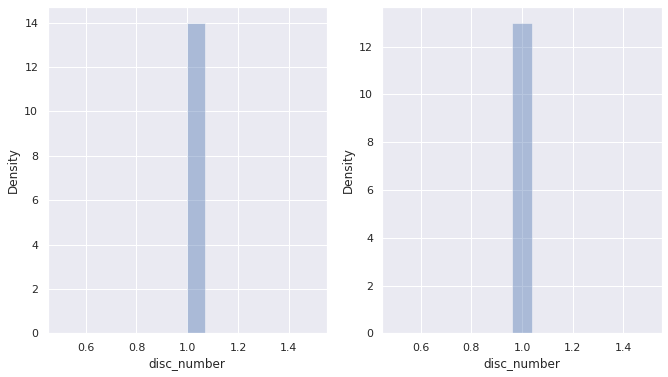

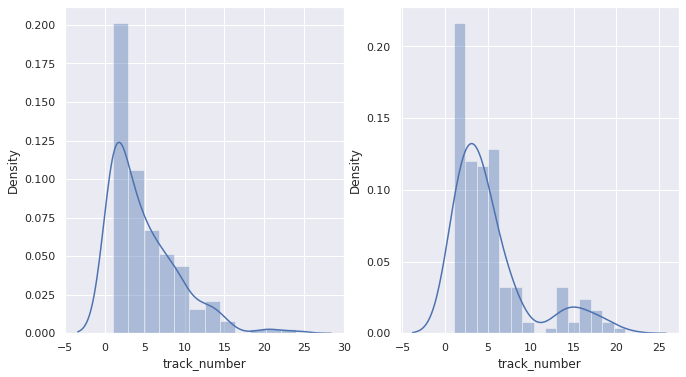

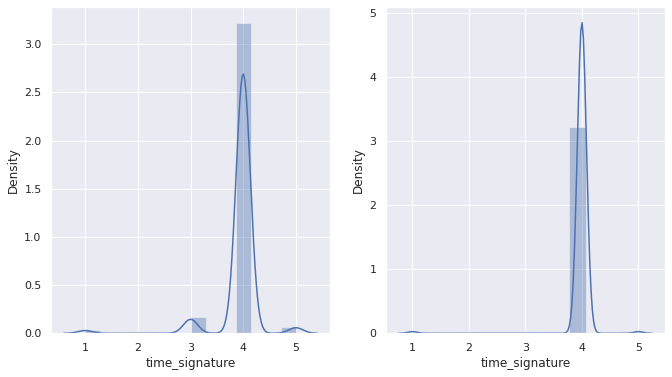

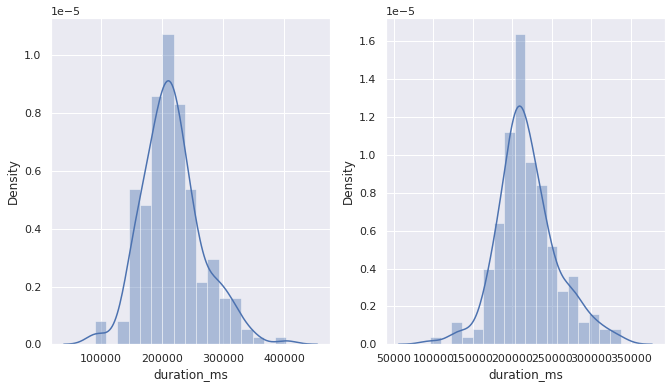

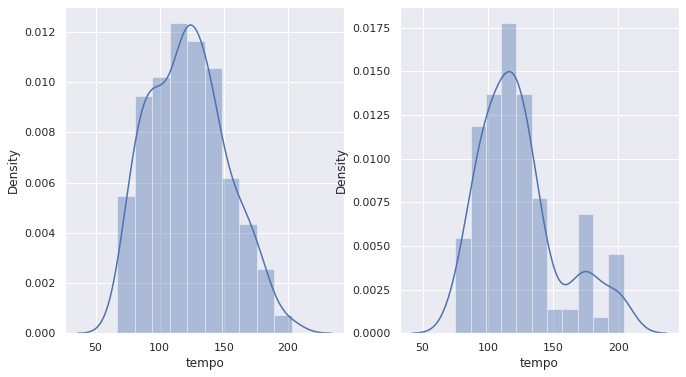

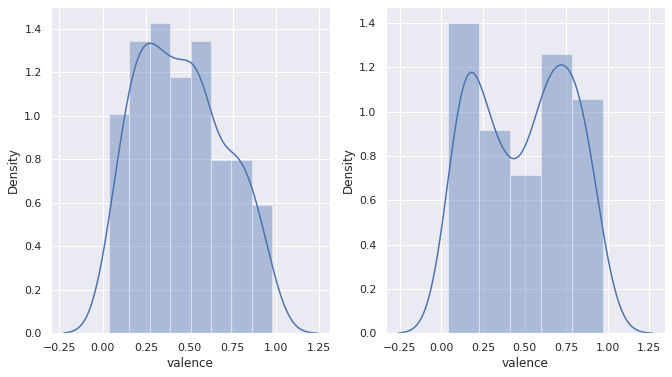

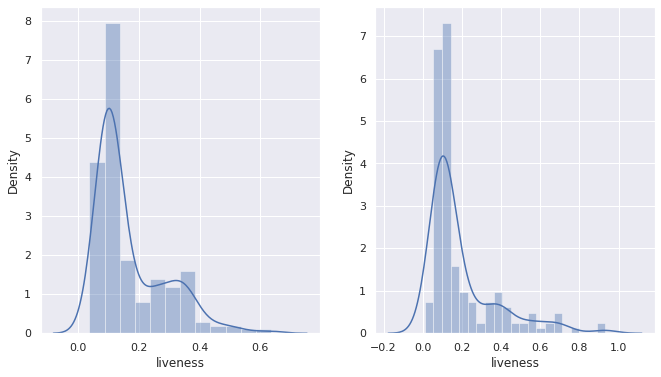

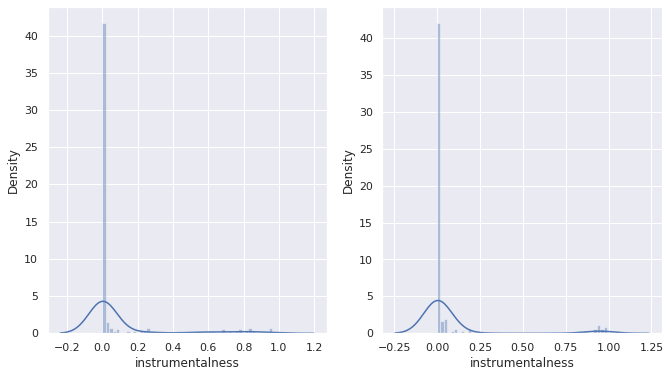

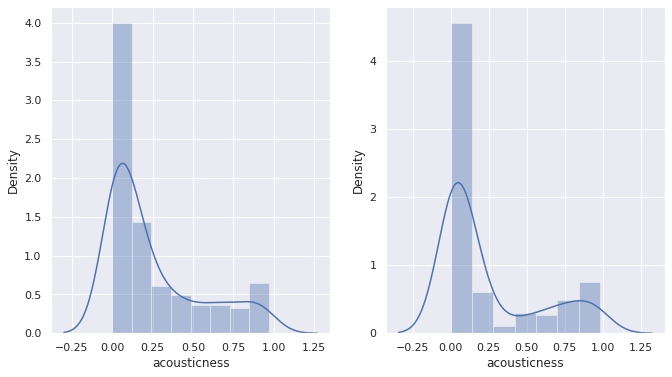

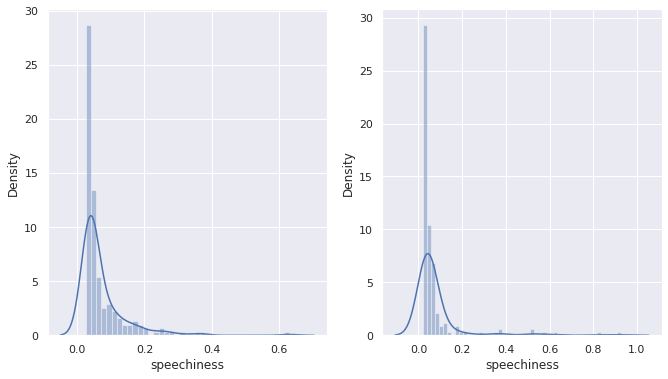

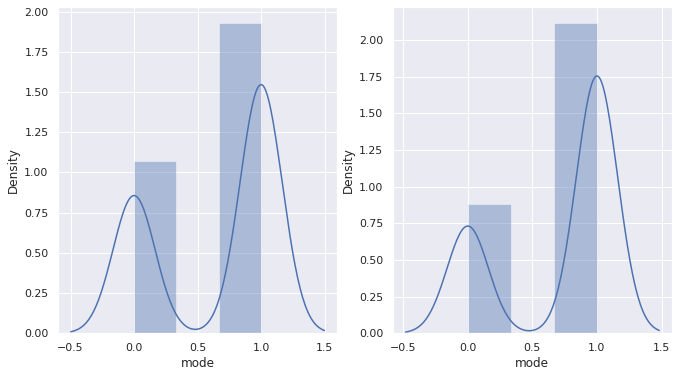

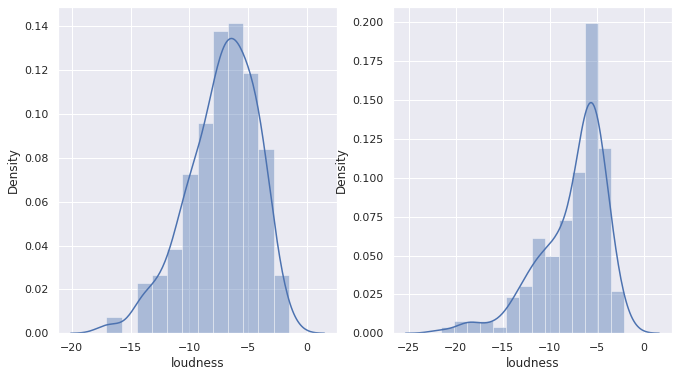

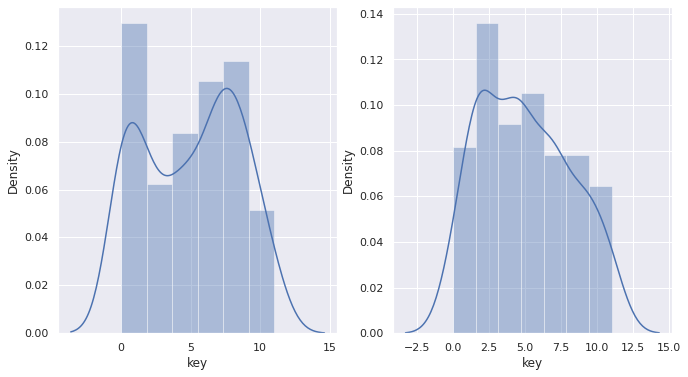

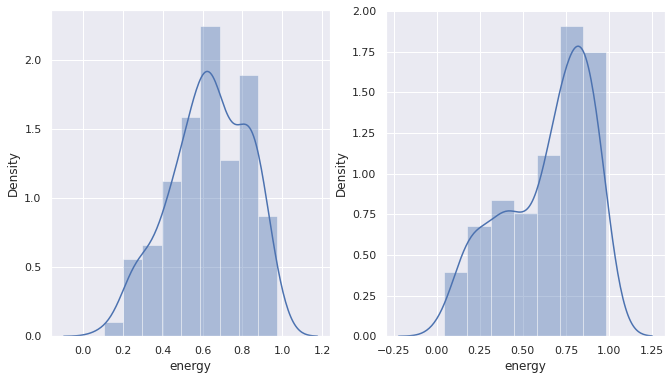

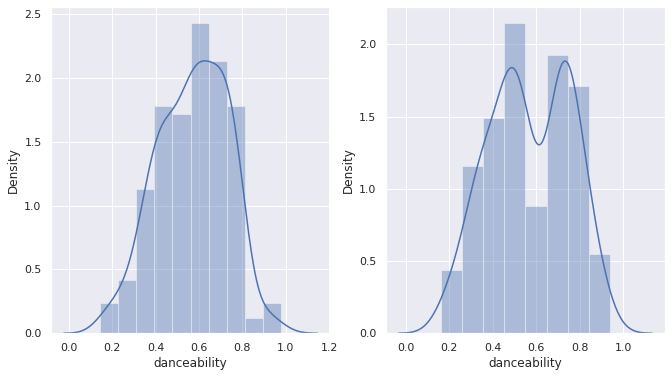

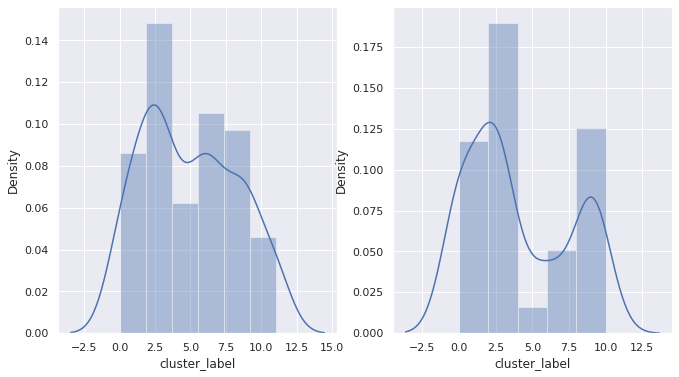

In [ ]:
for (i, feature) in enumerate(list(playlist_df.select_dtypes(np.number).columns)):
    fig, ax = plt.subplots(1, 2)
    sns.distplot(playlist_df[feature], ax=ax[0])
    sns.distplot(rec_songs[feature], ax=ax[1])